## Reproducibility when testing

In [88]:
# see https://pytorch.org/docs/stable/notes/randomness.html
# torch.manual_seed(0)

# when using cuda
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Getting Data

In [67]:
import os
from pathlib import Path
import scipy.io  # for reading matlab matrix
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [124]:
# custom DataSet class
class ParametrizedShirtDataSet(Dataset):
    """
    For loading the data of "Learning Shared Shape Space.." paper
    """
    
    def __init__(self, root_dir, transform = None):
        """
        Args:
            root_dir (string): Directory with all the t-shirt examples as subfolders
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.root_path = Path(root_dir)
        
        # list of items = subfolders
        self.datapoints_names = next(os.walk(self.root_path))[1]
        
        # datapoint folder structure
        self.mesh_filename = 'shirt_mesh_r.obj'
        self.pattern_params_filename = 'shirt_info.txt'
        self.pca_filename = 'visfea.mat'
        
        
    def __len__(self):
        """Number of entries in the dataset"""
        return len(self.datapoints_names)
    
    
    def read_pca(self, datapoint_name):
        """pca parameters from a given datapoint subfolder"""
        assert (self.root_path / datapoint_name / self.pca_filename).exists()
        
        matlab_mat = scipy.io.loadmat(self.root_path / datapoint_name / self.pca_filename)
        # assuming fea1 is what we need
        return np.asarray(matlab_mat['fea1']).squeeze()
    
    
    def read_pattern_params(self, datapoint_name):
        """9 pattern size parameters from a given datapoint subfolder"""
        assert (self.root_path / datapoint_name / self.pattern_params_filename).exists()
        
        # assuming that we need the numbers from the last line in file
        with open(self.root_path / datapoint_name / self.pattern_params_filename) as f:
            lines = f.readlines()
            params = np.fromstring(lines[-1],  sep = ' ')
        return params
        
    
    def __getitem__(self, idx):
        """Called when indexing: read the corresponding data. 
        Does not support list indexing"""
        
        if torch.is_tensor(idx):  # allow indexing by tensors
            idx = idx.tolist()
            
        datapoint_name = self.datapoints_names[idx]
        
        pca = self.read_pca(datapoint_name)
        
        # read the pattern parameters
        pattern_parameters = self.read_pattern_params(datapoint_name)
        
        sample = {'pca' : pca, 'pattern_params' : pattern_parameters}
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample
        

In [128]:
# Custom transforms -- to tensor
class SampleToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        pca, params = sample['pca'], sample['pattern_params']
        
        return {'pca': torch.from_numpy(pca).float(), 'pattern_params': torch.from_numpy(params).float()}

In [129]:
# Data Normalization?

In [130]:
# test loading
dataset = ParametrizedShirtDataSet(Path('D:\Data\CLOTHING\Learning Shared Shape Space_shirt_dataset_rest'), 
                                  SampleToTensor())

print (len(dataset))
print (dataset[1000]['pca'].shape)
print (dataset[1000]['pattern_params'].shape)
print (dataset[1000])

1050
torch.Size([100])
torch.Size([9])
{'pca': tensor([ 9.0149, 10.0000, 10.0000, 10.0000, 10.0000,  5.7808,  5.1910,  6.1884,
         1.9510,  1.6895,  2.1583,  2.8999,  4.4908,  4.8045,  5.8117,  6.2162,
         6.9980,  7.0324,  6.3759,  6.3499,  6.6360,  6.5454,  6.9373,  7.6318,
         7.3696,  6.6111,  6.3935,  5.8721, 10.0000, 10.0000, 10.0000, 10.0000,
         2.7178,  1.1612,  1.1830,  1.1401,  1.0348,  1.1202,  1.7733,  1.8811,
         1.8206,  2.0156,  1.9965,  1.3682,  1.1243,  1.0234,  1.0265,  1.0053,
         1.0459,  0.9955,  1.0309,  0.9502,  0.9865,  1.1324,  0.9609,  0.9914,
         1.1065,  0.9862,  1.1519,  1.0107,  0.9616,  0.9817,  0.9882,  0.9652,
         0.9811,  0.9486,  1.0291,  1.0376,  1.0312,  1.0907,  1.0268,  1.0780,
         1.1159,  1.1369,  1.0791,  1.0396,  1.1149,  1.1024,  1.1467,  1.2941,
         0.9927,  1.0200,  1.0849,  0.9808,  0.9873,  0.9746,  0.9548,  0.9753,
         0.9825,  0.9796,  0.9285,  1.2289,  1.5788,  2.1209,  2.6923,  2

# Defining a Net

In [90]:
import torch.nn as nn
import torch.functional as F

In [133]:
class ShirtPCAMLP(nn.Module):
    """MLP for training on shirts dataset. Assumes 100 PCA parameters used"""
    
    def __init__(self):
        super().__init__()
        
        # layers definitions
        self.sequence = nn.Sequential(
            nn.Linear(100, 120), 
            nn.ReLU(), 
            nn.Linear(120, 80), 
            nn.ReLU(), 
            nn.Linear(80, 60),
            nn.ReLU(),
            nn.Linear(60, 9)
        )
    
    def forward(self, x_batch):
        return self.sequence(x_batch)

In [94]:
net = ShirtPCAMLP()

print (net)

ShirtPCAMLP(
  (sequence): Sequential(
    (0): Linear(in_features=100, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=10, bias=True)
  )
)


# Training

In [131]:
# Data load and split
shirt_dataset = ParametrizedShirtDataSet(Path('D:\Data\CLOTHING\Learning Shared Shape Space_shirt_dataset_rest'), 
                                  SampleToTensor())

valid_size = (int) (len(shirt_dataset) / 10)
# split is RANDOM. Might affect performance
training_set, validation_set = torch.utils.data.random_split(
    shirt_dataset, 
    (len(shirt_dataset) - valid_size, valid_size))

print ('Split: {} / {}'.format(len(training_set), len(validation_set)))

training_loader = DataLoader(training_set, batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size)

Split: 945 / 105


In [159]:
# Basic Parameters
batch_size = 64
epochs_num = 100
learning_rate = 0.1

In [205]:
# Training loop func

def fit(model, regression_loss, optimizer, train_loader):
    
    validation_losses = []
    running_losses = []
    
    for epoch in range (epochs_num):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(training_loader):
            preds = model(batch['pca'])
            
            loss = regression_loss(preds, batch['pattern_params'])
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            # logging
            running_loss += loss.item()
            #if i % 5 == 4:
            #    print ('Epoch: {}, Step: {}, Loss: {}'.format(epoch, i, running_loss))
            #    running_loss = 0.0 # start over from the logged point
            
        running_losses.append(running_loss / (len(training_loader)))
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[(regression_loss(model(batch['pca']), batch['pattern_params']), len(batch)) for batch in validation_loader]
            )
            
        valid_loss = np.sum(losses) / np.sum(nums)
        validation_losses.append(valid_loss)
        print ('Epoch: {}, Validation Loss: {}'.format(epoch, valid_loss))
        
    return validation_losses, running_losses

In [206]:
# Get all the definitions
# model
model = ShirtPCAMLP()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# loss function
regression_loss = nn.MSELoss()

In [207]:
# train

validation_losses, running_losses = fit(model, regression_loss, optimizer, training_loader)

print ("Finished training")

Epoch: 0, Validation Loss: 0.03244992718100548
Epoch: 1, Validation Loss: 0.02951507642865181
Epoch: 2, Validation Loss: 0.06014000624418259
Epoch: 3, Validation Loss: 0.02415366843342781
Epoch: 4, Validation Loss: 0.04062524810433388
Epoch: 5, Validation Loss: 0.015570399351418018
Epoch: 6, Validation Loss: 0.021423306316137314
Epoch: 7, Validation Loss: 0.0110200559720397
Epoch: 8, Validation Loss: 0.013582885265350342
Epoch: 9, Validation Loss: 0.01229143887758255
Epoch: 10, Validation Loss: 0.01351252757012844
Epoch: 11, Validation Loss: 0.007512715645134449
Epoch: 12, Validation Loss: 0.00809786468744278
Epoch: 13, Validation Loss: 0.008079607039690018
Epoch: 14, Validation Loss: 0.011633642017841339
Epoch: 15, Validation Loss: 0.004317091312259436
Epoch: 16, Validation Loss: 0.005825447849929333
Epoch: 17, Validation Loss: 0.0042252917774021626
Epoch: 18, Validation Loss: 0.004897519946098328
Epoch: 19, Validation Loss: 0.005026494152843952
Epoch: 20, Validation Loss: 0.005227731

# Visualization

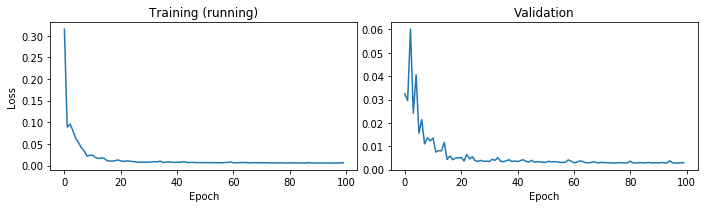

In [208]:
# visuaize losses
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title("Training (running)")
plt.plot(running_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title("Validation")
plt.plot(validation_losses)
plt.xlabel('Epoch')

plt.show()


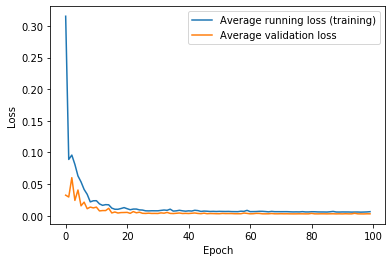

In [209]:
# on the same plot
plt.plot(running_losses, label = "Average running loss (training)")
plt.plot(validation_losses, label = "Average validation loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [210]:
# loss on validation set
valid_loss = sum([regression_loss(model(batch['pca']), batch['pattern_params']) for batch in validation_loader]) 

print ('Validation loss: {}'.format(valid_loss))

Validation loss: 0.011753877624869347
